## Start to finish

This notebook will serve as my testing for the whole process of starting with a video and ending with an averaged image. Once I have this down I'll be able to write a function that can do this all in one swoop, taking in a video and outputting an image of the frames averaged together.

To start, we need to import the video.

In [1]:
import cv2
import numpy as np
import os
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
def get_saving_frames_durations(cap, saving_fps):
    '''A function that returns the list of durations where to save the frames'''
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

In [39]:
def save_video_frames(video_file, SAVING_FRAMES_PER_SECOND):
    '''A function that saves the individual frames of a video, returning a list containing
    each frame, saved as an image saved in a numpy array.
    
    Saving frames per second is the desired number of frames to be saved from each second
    of the video.
    '''
    
    # read the video file
    cap = cv2.VideoCapture(video_file)
    
    # get the fps of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # if the SAVIGN_FRAMES_PER_SECOND is above video fps, then set it to fps (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    
    # get the list and duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    
    # start the loop
    count = 0
    all_frames = []
    while True:
        is_read, frame = cap.read()
        frame = frame[...,::-1]
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            all_frames.append(frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1
    
    # video = np.stack(all_frames, axis=0)
    return all_frames

In [40]:
video_file = "football.mp4"
saving_frames_per_second = 1
frames = save_video_frames(video_file, saving_frames_per_second)

In [53]:
def average_frames(frames):
    '''A function that returns the average image from all frames in a list.'''
    
    number_of_frames = len(frames)
    
    # Initialize average_frame. We will be adding the rest of the frames in the for loop
    average_frame = frames[0] / number_of_frames
    for i in range(1, len(frames)):
        average_frame += frames[i] / number_of_frames
    
    return np.uint8(average_frame)

In [54]:
average = average_frames(frames)

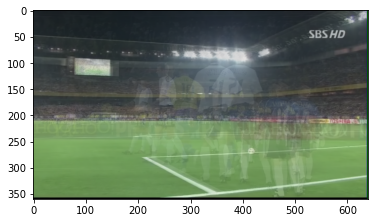

In [56]:
plt.imshow(average)

Success!!!

Now lets define the function that does all of it for us!

In [61]:
def process_video(video_file, SAVING_FRAMES_PER_SECOND):
    frames = save_video_frames(video_file, SAVING_FRAMES_PER_SECOND)
    average = average_frames(frames)
    return average

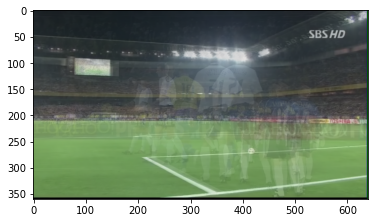

In [63]:
image = process_video("football.mp4", 1)
plt.imshow(image)

AMAZING! Now we have a way to convert videos into images that can be processed by CLIP. We should try to test different saving frame rates to see which optimize the performance of CLIP.

And just to see lets run this one through CLIP to see if it can tell what image we're looking at.

In [66]:
import os
import clip
import torch

In [67]:
model, preprocess = clip.load("ViT-B/32", device = 'cpu')

image = Image.fromarray(average)

In [69]:
image_input = preprocess(image).unsqueeze(0).to("cpu")

# create some fake labels
labels = ['a photo of a soccer match', 
          'a photo of a rugby game',
          'a photo of game show', 
          'a photo of a bowl of fruit',
          'a photo of the pacific ocean']

text_inputs = clip.tokenize(labels)

with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
    
    logits_per_image, logits_per_text = model(image_input, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Predictions:\n")
for i in range(5):
    print(f"{labels[i]:>30s}: {100 * probs[0, i]:.2f}%")

Predictions:

     a photo of a soccer match: 98.98%
       a photo of a rugby game: 0.74%
          a photo of game show: 0.26%
    a photo of a bowl of fruit: 0.01%
  a photo of the pacific ocean: 0.01%


#### Wonderful. Onto the next step.